# Reference and science mean combined with the same scale


## Functions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import fnmatch
import os
from astropy.io import fits
from skimage.measure import EllipseModel
from matplotlib.patches import Ellipse
from scipy import interpolate
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from textwrap import wrap
import scipy.ndimage as ndimage
from matplotlib.gridspec import GridSpec
from matplotlib import colors
import functions as f
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp
import functions as f


def plotImage(image, lim):
    n = image.shape[0]
    
    fig, ax = plt.subplots()
    image = np.arcsinh(image)
    max = np.max(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    min=np.min(image[int(n/2-lim/2):int(n/2+lim/2),int(n/2-lim/2):int(n/2+lim/2)])
    ps = 3.6 #mas per pixel for zimpol
    d = n * ps / 2
    plt.imshow(image, vmin=min, vmax=max, extent=(-d, d, d, -d))
    #plt.plot(0, 0, "+", color="red")
    plt.xlim(-lim * ps, lim * ps)
    plt.ylim(-lim * ps, lim * ps)
    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.colorbar()
    plt.tight_layout

In [5]:


def createfolder(dirName):
    try:
    # Create target Directory
       os.mkdir(dirName)
    except FileExistsError:
        print()#("Directory " , dirName ,  " already exists")   
        
  

    
def gaus(x,a,x0,sigma):
            return a*np.exp(-(x-x0)**2/(2*sigma**2))

    
def find_FWHM (PSF,n,ps,figfolder,title):             #resolution
    middle=int(n/2)

    y1=PSF[middle,middle-60:middle+60]
    y2=PSF[middle-60:middle+60,middle]

    xdata = np.linspace(middle-60,middle+60, num=len(y1))


    n_gauss = len(xdata) #the number of data
    amp=np.max(y1)
    mean = np.sum(xdata * y1) / sum(y1)
    sigma = np.sqrt(sum(y1 * (xdata - mean)**2) / sum(y1))

    popt1,pcov1 = curve_fit(gaus,xdata,y1,p0=[amp,mean,sigma])
    popt2,pcov2 = curve_fit(gaus,xdata,y2,p0=[amp,mean,sigma])


    plt.plot(xdata, y1, 'o', label='vertical')
    plt.plot(xdata, gaus(xdata,*popt1), '-', label='fit1')
    plt.plot(xdata, y2, 'o', label='horizotal')
    plt.plot(xdata, gaus(xdata,*popt2), '-', label='fit2')
    plt.legend()
    plt.title(title)
    plt.savefig(figfolder+title+'.jpeg',bbox_inches='tight', pad_inches=0.1)
    plt.close()

    fwhm1=2*np.sqrt(2*math.log(2))*popt1[2]
    fwhm2=2.355*popt2[2]


    fwhm=(abs(fwhm1)+abs(fwhm2))/2

    return fwhm



def calculate_unresolved(correction_radius, q, u,i,ps,R,normlim):
    # Calculates degree and angle of unresolved polarisation
    #resulting values are in fraction (not %) for dolp, and in degrees for aolp
    

    mask=(R<=correction_radius)

    normalisation=np.sum(i[R<=1500/ps])
    q_over_i=np.divide(q,i,where=i!=0)   
    cq=np.median(q_over_i[mask]) #for median normal as in IRDIS
    u_over_i=np.divide(u,i,where=i!=0)    
    cu=np.median(u_over_i[mask]) #for median normal as in IRDIS
    aolp_unres=np.rad2deg(0.5*np.arctan2(cu, cq))
    #print(aolp_unres)
    if aolp_unres<0 : 
        aolp_unres=aolp_unres+180
    dolp_unres=np.sum(np.sqrt(cu*i*cu*i+ cq*i*cq*i)*(R<=normlim))/normalisation
    
    q_corr=q-cq*i
    u_corr=u-cu*i
    return dolp_unres, aolp_unres,q_corr,u_corr
    

    
    
def plot_AoLP(ps,Q,U,R,I,Q_PHI,title,save,plot,noise,lim):
    
    n = Q_PHI.shape[0]
    Q=Q[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    U=U[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    R=R[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    I=I[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    Q_PHI=Q_PHI[int(n/2-lim):int(n/2+lim),int(n/2-lim):int(n/2+lim)]
    
    
    
    # First, we plot the background image
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    n = Q_PHI.shape[0]
    d = n * ps / 2

    im1=ax.imshow(np.arcsinh(Q_PHI), origin='lower',extent=(-d, d, d, -d))
    #plt.xlim(-lim * ps, lim * ps)
    #plt.ylim(-lim * ps, lim * ps)
    fig.colorbar(im1, orientation='vertical',shrink=0.75)

    plt.xlabel('mas')
    plt.ylabel("mas")
    plt.tight_layout(pad=0.1)     

    # ranges of the axis
    xx0, xx1 = ax.get_xlim()
    yy0, yy1 = ax.get_ylim()

    # binning factor
    factor = [1, 1]

    # re-binned number of points in each axis
    nx_new = Q_PHI.shape[1] // factor[0]
    ny_new = Q_PHI.shape[0] // factor[1]

    # These are the positions of the quivers
    X,Y = np.meshgrid(np.linspace(xx0,xx1,nx_new,endpoint=True),
                      np.linspace(yy0,yy1,ny_new,endpoint=True))
    # bin the data
    Q_bin = Q.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    U_bin = U.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    I_bin = I.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    Q_phi_bin = Q_PHI.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    R_bin=R.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    
    #Here you have to recalculate the AoLP (marked as psi) for the binned data. If you try to just bin AoLP it wil mess up angles
    psi=0.5*np.arctan2(U_bin, Q_bin)
    
    
    #mask1=mask1.reshape(nx_new, factor[0], ny_new, factor[1]).sum(3).sum(1)
    
    # polarization fraction
    frac =Q_phi_bin/I_bin
    
    # mask to show only alighned

    mask1=maskcrit(psi,R_bin)
    mask2=Q_phi_bin>=noise*5
    mask=mask2*mask1
    
    
    #print('max DoLP in region %.3f percent'%(np.max(frac[mask])*100))

    #+pi/2 because quiver function start counting from the horizontal axis counterclockwise 
    #and the AoLP have to start from North to East (which is also counterclockvise)
    pixX = frac*np.cos(psi+np.pi/2) # X-vector 
    pixY = frac*np.sin(psi+np.pi/2) # Y-vector

    # keyword arguments for quiverplots
    quiveropts = dict(headlength=0, headwidth=1, pivot='middle', color='w')
    ax.quiver(X[mask], Y[mask], pixX[mask], pixY[mask],scale=2, **quiveropts)

    
    mask=mask.astype(int)
    levels = [0,1]  # Adjust this as needed
    CS = ax.contour(X, Y, mask, levels=levels, colors=['white'], extent=(-d, d, d, -d))
    #ax.clabel(CS, inline=True, fontsize=10)
    
    plt.title(title)
    if save!=False:
        plt.savefig(save,bbox_inches='tight', pad_inches=0.1)
    if plot!=False:
        plt.show()
    plt.close()
    
    
    
def Loadimages(star,fittype,dirdat,band, extension):
    dir = dirdat
    qfile = star+'_'+band+'_'+fittype+extension+'.fits'
    print(dir,qfile)
    print(qfile)
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                print(image[1,4])
                n = image.shape[0]
                
    return image, n

def Loadimagespsf(star,dirdat,band):
    dir = dirdat
    qfile = '*_'+band+'_I_meancombined.fits'
    files = os.listdir(dir)
    image=[]
    for file in files:
        if fnmatch.fnmatch(file, qfile):
            with fits.open(dir + file) as hdul:
                image = hdul[0].data
                n = image.shape[0]

                print(n)
    return image, n


def plot_with_same_color(data, keys, labels,title,star,lim1,arcsinh,cameras):
    #min and max values setted manually here to 0 and 1
    num_keys = len(keys)
    ncols = 3#int(np.ceil(np.sqrt(num_keys)))  # Adjust the number of rows as needed
    nrows = 1#int(np.ceil(num_keys / ncols))
    fig = plt.figure(figsize=(18, 6))
    data_arcshin={}
    for idx, key in enumerate(keys):
        if arcsinh==True:
            data_arcshin[key] =np.arcsinh(data[key]) 
        else:
            data_arcshin[key] = data[key]
    # Using GridSpec to create a more flexible subplot layout
    gs = GridSpec(nrows, ncols, figure=fig, wspace=0.1, hspace=0.25)
    # Calculate vmin and vmax for all images
    n = data_arcshin[key].shape[0]
    vmin = min(data_arcshin[key][int(n/2-lim1):int(n/2+lim1),int(n/2-lim1):int(n/2+lim1)].min() for key in keys)
    vmax =max(data_arcshin[key][int(n/2-lim1):int(n/2+lim1),int(n/2-lim1):int(n/2+lim1)].max() for key in keys)

    for idx, key in enumerate(keys):
        if cameras[idx]=='IRDIS':
            ps=12.27
            lim=lim1*1.0
        else:
            ps=3.6
            lim=lim1*12.27/3.6
            
        ax = fig.add_subplot(gs[idx])
        n = data_arcshin[key].shape[0]
        d = (n-1) * ps / 2
        im = ax.imshow(data_arcshin[key], extent=(-d, d, d, -d), vmin=vmin, vmax=vmax)#,origin='lower')
        #plotting contour
        levels=[np.max(data_arcshin[key])/4,np.max(data_arcshin[key])/2]
        #CS=ax.contour(data_arcshin[key], levels=levels,colors=['pink','white'], extent=(-d, d, d, -d))
        #ax.clabel(CS, inline=True, fontsize=10)
        
        ax.set_title(labels[key])
        ax.set_xlabel('mas')
        ax.set_ylabel('mas')
        ax.set_xlim(-lim * ps, lim * ps)
        ax.set_ylim(-lim * ps, lim * ps)
        ax.label_outer()

    # Create a common colorbar for all images
    cax = fig.add_axes([0.95, 0.22, 0.02, 0.55])  # Adjust the position of colorbar as needed
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(star+' '+title, fontsize=16)#,y=0.85)

    #specific_folder=figfolder+'models/'
    #try:
    # Create target Directory
    #   os.mkdir(specific_folder)
    #except FileExistsError:
    #    print("Directory " , specific_folder,  " already exists")
   
    #plt.savefig(specific_folder +star+'_'+title+".jpeg",bbox_inches='tight', pad_inches=0.1)
    plt.savefig(figfolder+star+'_'+band[int(fittype)-1]+'_'+title+'_vs_ref.png')
    plt.show()
    plt.close()
    
def normalize(arr):
    rng = arr.max()-arr.min()
    amin = arr.min()
    return (arr-amin)*1/rng #normalised to [0,1]

def compare(img1, img2):
    # normalize to compensate for exposure difference
    
    img1 = normalize(img1)
    img2 = normalize(img2)
    # calculate the difference and its norms
    diff = img1 - img2  # elementwise for scipy arrays
    m_norm = np.sum(abs(diff))/np.sum(img1)  

    return m_norm

## Set up

In [6]:

#stars=['IRAS08544-4431', 'IRAS08544-4431_dc_notnorm','AR_Pup','AR_Pup_dc_notnorm']
stars=['AR_Pup_dc_notnorm','HR4049_20190108','HR4049_20190107',"HR4049_combined",'V709_Car','HR4226','UMon_Katya']

star = stars[0]

#star='IRAS08544-4431_dc_notnorm'

starnames = {'HD75885':'HD75885','AR_Pup':'AR_Pup','HR4049/2019-01-08':'HR4049-2019-01-08','HR4049/2019-01-07':'HR4049-2019-01-07','IRAS08544-4431':'IRAS08544-4431','UMon':'UMon','AR_Pup_flat4':'AR_Pup_flat4','V709_Car':'V709_Car','UMon_calibV390':'UMon_calibV390','HR4224':'HR4224'}
stars_type={'HD83878':'ref','IRAS08544-4431_dc_notnorm':'sci','HD75885':'ref', 'AR_Pup_dc_notnorm':'sci','UMon':'sci','UMon_Katya':'sci','HR4049_20190108':'sci','HR4049_20190107':'sci','HD71253':'ref','HD94680':'ref','HD96314':'ref','HD98025':'ref','V709_Car':'sci','HR4226':'sci'}
ref_of_sci={'AR_Pup_dc_notnorm':'HD75885','UMon':'HD71253','UMon_Katya':'HD71253','V709_Car':'HD94680','HR4049_20190108':'HD96314','HR4049_20190107':'HD96314','HR4226':'HD98025',"HR4049_combined":'HD96314'} #the corresponding scientific targets, SPHERE proposals

fittypes=['1', '2']

band=['V','I']
ps=3.6



## Code


V
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_V_Q_phi_meancombined.fits
AR_Pup_dc_notnorm_V_Q_phi_meancombined.fits
1.0000000000000003e-16
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_V_U_phi_meancombined.fits
AR_Pup_dc_notnorm_V_U_phi_meancombined.fits
0.0
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_V_PI_meancombined.fits
AR_Pup_dc_notnorm_V_PI_meancombined.fits
0.0
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_V_Q_phi_corr_tel+unres.fits
AR_Pup_dc_notnorm_V_Q_phi_corr_tel+unres.fits
1e-16
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_V_U_phi_corr_tel+unres.fits
AR_Pup_dc_notnorm_V_U_phi_corr_tel+unres.fits
0.02813288234033445
/media/kateryna/Data_Lin/PhD/SPHERE_reducti

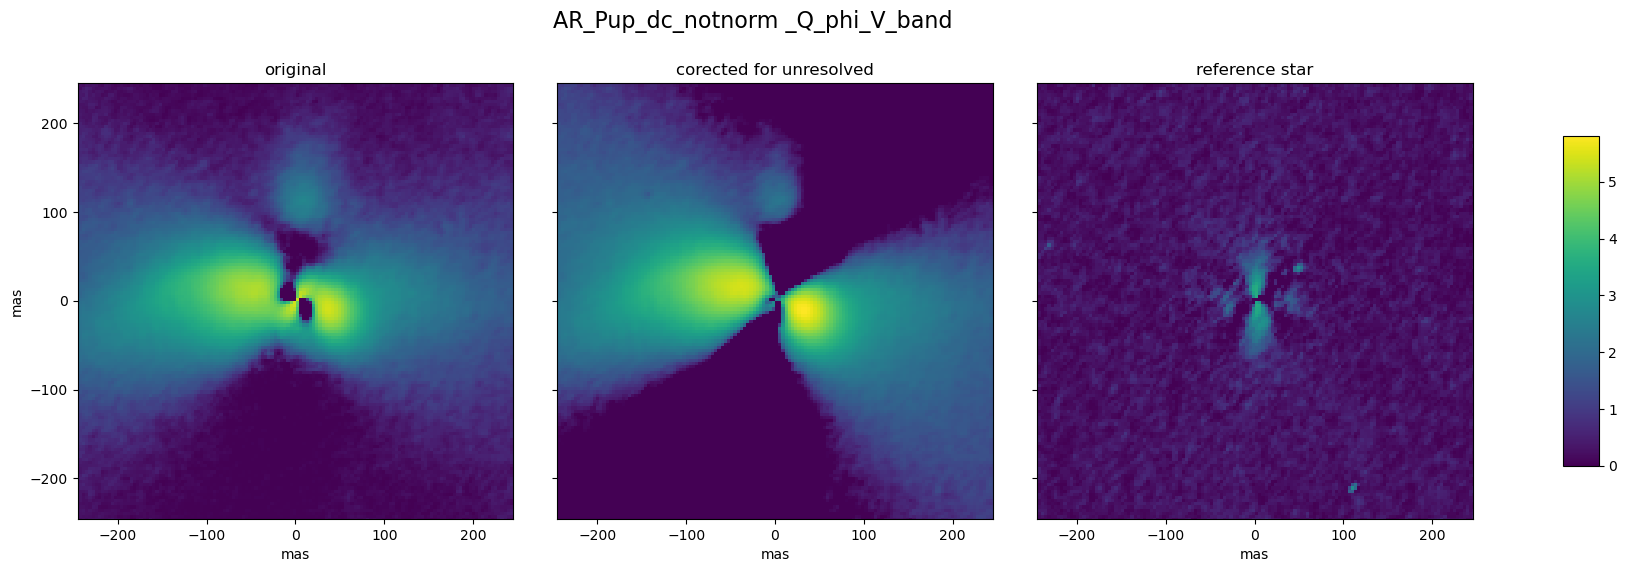

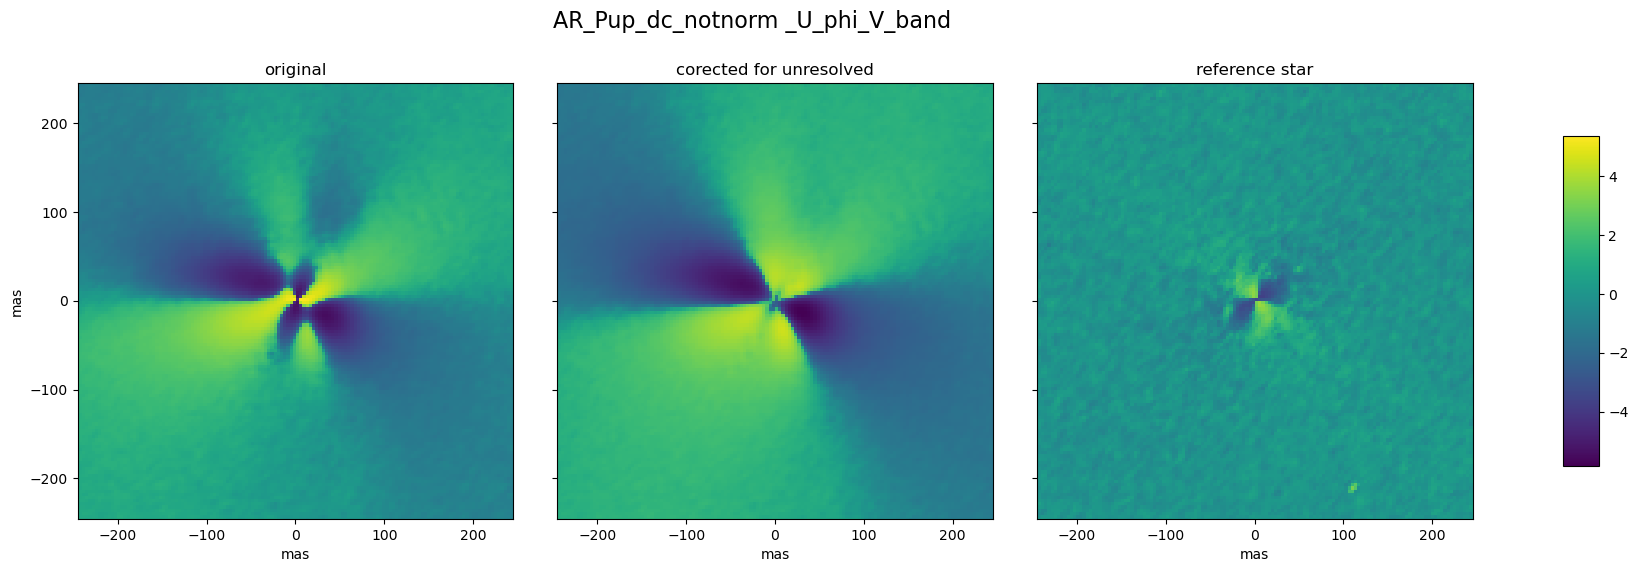

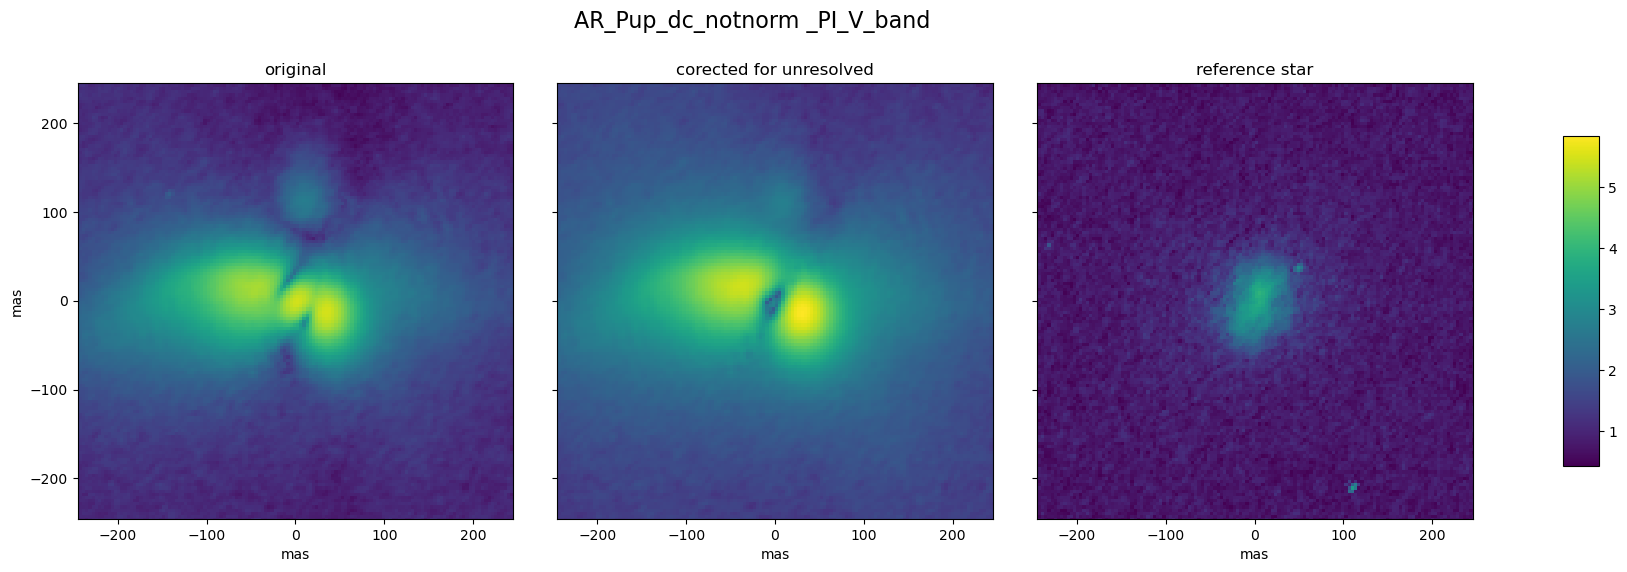

I
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_I_Q_phi_meancombined.fits
AR_Pup_dc_notnorm_I_Q_phi_meancombined.fits
1.0000000000000003e-16
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_I_U_phi_meancombined.fits
AR_Pup_dc_notnorm_I_U_phi_meancombined.fits
0.0
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_I_PI_meancombined.fits
AR_Pup_dc_notnorm_I_PI_meancombined.fits
0.0
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_I_Q_phi_corr_tel+unres.fits
AR_Pup_dc_notnorm_I_Q_phi_corr_tel+unres.fits
1e-16
/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/Unres+PSFcorr/AR_Pup_dc_notnorm/ AR_Pup_dc_notnorm_I_U_phi_corr_tel+unres.fits
AR_Pup_dc_notnorm_I_U_phi_corr_tel+unres.fits
0.04011639170570929
/media/kateryna/Data_Lin/PhD/SPHERE_reductio

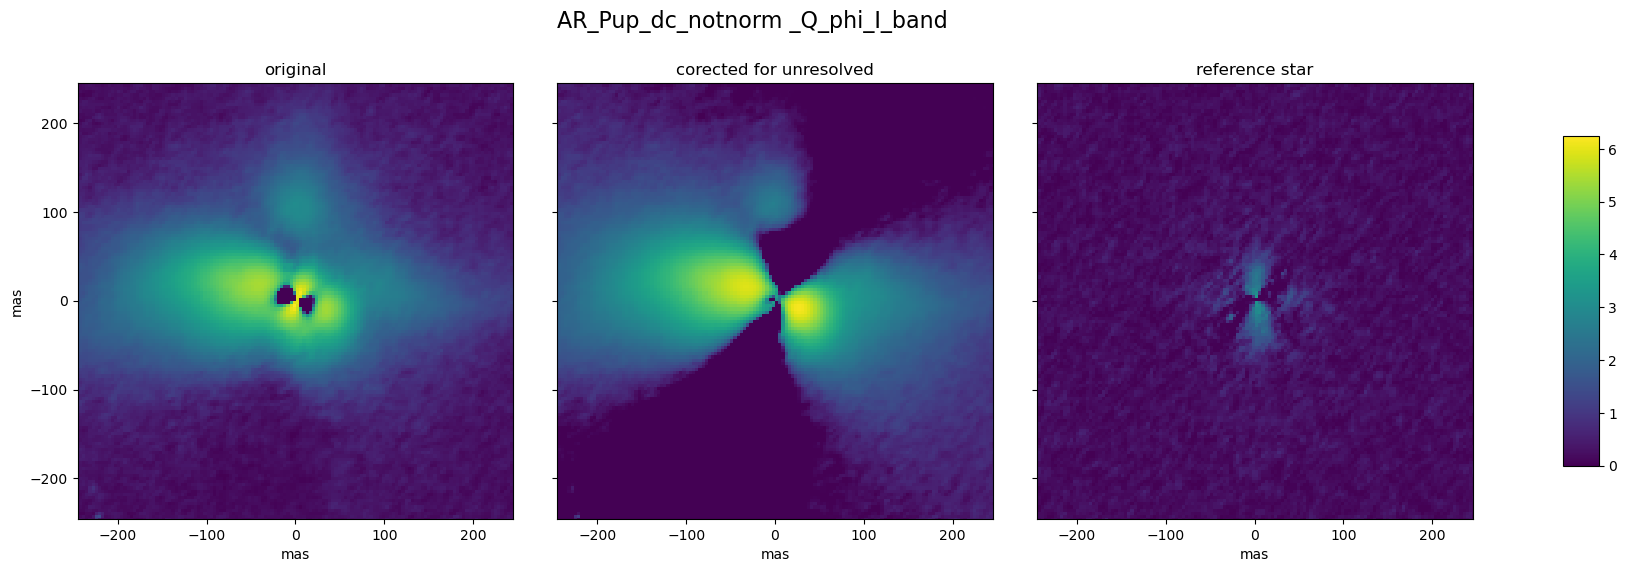

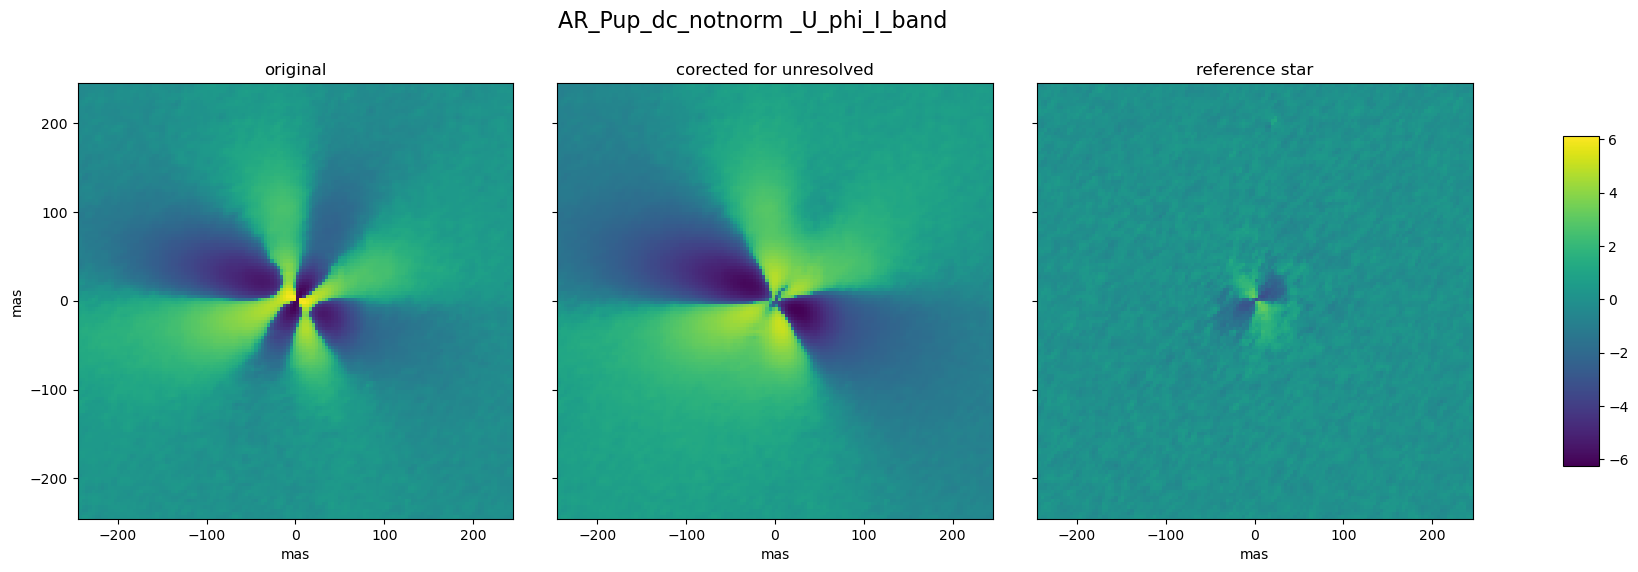

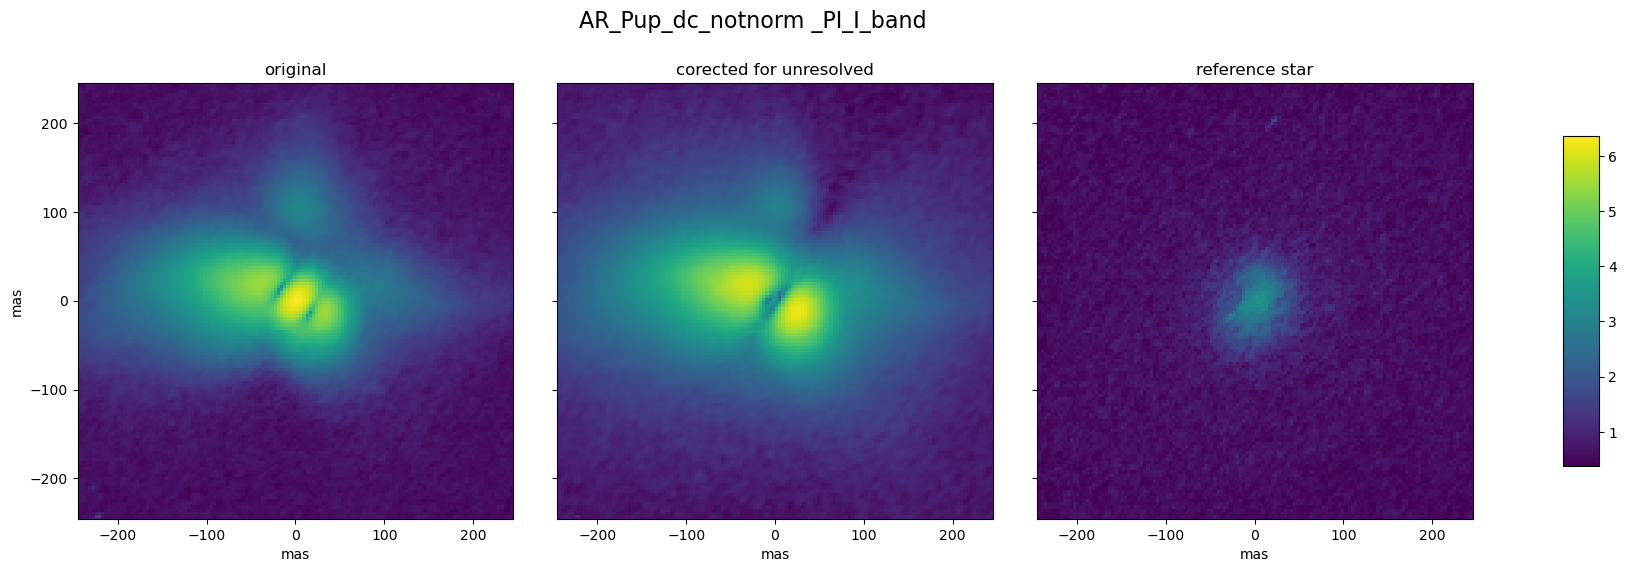

In [7]:

dirdat ='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Unres+PSFcorr/'+star+'/'
dirdat_ref ='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Unres+PSFcorr_Ref/'+ref_of_sci[star]+'/'

figfolder='/media/kateryna/Data_Lin/PhD/SPHERE_reduction_data/paper3/'+'Ref+sci_image/'
createfolder(figfolder)


#limit for normalisation
normlim=125/ps
ps=3.6
correction_radius=3

for fittype in fittypes:
    print(band[int(fittype)-1])
    
    
    q_phi, n=Loadimages(star,'Q_phi',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
    u_phi, n=Loadimages(star,'U_phi',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
    pi, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_meancombined') #+PSF_smear
    q_phi_corr, n=Loadimages(star,'Q_phi',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear
    u_phi_corr, n=Loadimages(star,'U_phi',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear
    pi_corr, n=Loadimages(star,'PI',dirdat,band[int(fittype)-1],'_corr_tel+unres') #+PSF_smear
    q_phi_ref, n=Loadimages(ref_of_sci[star],'Q_phi',dirdat_ref,band[int(fittype)-1],'_meancombined') #+PSF_smear
    u_phi_ref, n=Loadimages(ref_of_sci[star],'U_phi',dirdat_ref,band[int(fittype)-1],'_meancombined') #+PSF_smear
    pi_ref, n=Loadimages(ref_of_sci[star],'PI',dirdat_ref,band[int(fittype)-1],'_meancombined') #+PSF_smear
    
    
    
    #Creating grid         
    xr = np.linspace(-n/2, n/2, num=n)
    yr = np.linspace(-n/2, n/2, num=n)
    x0 = 0.5
    y0 = 0.5
    xr = xr-x0
    yr = yr-y0
    Xr, Yr = np.meshgrid(xr, yr)
    R = np.sqrt(Xr**2 + Yr**2)
    phi = np.arctan(Yr/Xr)

    

    
    
    keys=['sci','sci_corr','ref']
    labels={'sci':'original','sci_corr':'corected for unresolved','ref':'reference star'}
    cameras=['ZIMPOL','ZIMPOL','ZIMPOL']

    data={'sci':q_phi,'sci_corr':q_phi_corr,'ref':q_phi_ref}
    plot_with_same_color(data, keys, labels ,'_Q_phi_'+band[int(fittype)-1]+ '_band',star, 20,True,cameras)
    
    
    data={'sci':u_phi,'sci_corr':u_phi_corr,'ref':u_phi_ref}
    plot_with_same_color(data, keys, labels ,'_U_phi_'+band[int(fittype)-1]+ '_band',star, 20,True,cameras)
    
    data={'sci':pi,'sci_corr':pi_corr,'ref':pi_ref}
    plot_with_same_color(data, keys, labels ,'_PI_'+band[int(fittype)-1]+ '_band',star, 20,True,cameras)
    


# 